In [1]:
#importing libraries

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine 
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from datetime import datetime

<h1> Exploratory Data Analysis </h1>

<h2> Data Loading and Cleaning </h2>

<h3> Using Pandas with SQLite to Load the data</h3>

In [15]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    chunksize = 150
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

<h3> Counting the number of rows </h3>

In [6]:
if os.path.isfile('train.db'):
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
else:
    print("train.db file not found :(")

Number of rows in the database : 
 6034196


<h3> Checking for duplicates </h3>

In [2]:
if os.path.isfile('train.db'):
    con = sqlite3.connect('train.db')
    no_dup_rows = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as Count FROM data GROUP BY Title, Body, Tags', con)
    con.close()
else:
    print("train.db file not found :(")

In [3]:
no_dup_rows.head()

,Title,Body,Tags,Count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [69]:
print('Nummber of duplicate questions: ', num_rows['count(*)'].values[0] - no_dup_rows.shape[0], ':', ((num_rows['count(*)'].values[0] - no_dup_rows.shape[0])/num_rows['count(*)'].values[0])*100, '%')

Number of duplicate questions : 1827881 ( 30.2920389063 % )


In [5]:
# number of times each question appeared in our database
no_dup_rows['Count'].value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: Count, dtype: int64

In [6]:
no_dup_rows["tag_count"] = no_dup_rows["Tags"].apply(lambda text: len(text.split(" ")) if not pd.isnull(text) else 0)
no_dup_rows.head()

,Title,Body,Tags,Count,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [7]:
# distribution of number of tags per question
no_dup_rows['tag_count'].value_counts()

3    1206157
2    1111706
4     814996
1     568291
5     505158
0          7
Name: tag_count, dtype: int64

<h3> Saving unique observations in seperate database </h3>

In [10]:
no_dup_rows.to_csv('no_duplicate_CSV.csv', sep=',', index=False, header=no_dup_rows.columns, encoding='utf-8')

In [2]:
#Creating db file from csv
if not os.path.isfile('no_dup_train.db'):
    disk_engine = create_engine('sqlite:///no_dup_train.db')
    chunksize = 150
    j = 0
    index_start = 1
    for df in pd.read_csv('no_duplicate_CSV.csv', names=['Title', 'Body', 'Tags', 'Count', 'tag_count'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        df.to_sql('no_dup_train', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [3]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('no_dup_train.db'):
    con = sqlite3.connect('no_dup_train.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
else:
    print("no_dup_train.db file not found :(")

In [8]:
tag_data.dropna(inplace=True)

In [9]:
tag_data.shape

(4206308, 1)

<h2> Analysis of Tags </h2>

<h3> Total number of unique tags </h3>

In [10]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [11]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206308
Number of unique tags : 42048


In [13]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


<h3> Number of times a tag appeared </h3>

In [14]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [15]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict.csv'):
    with open('tag_counts_dict.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [16]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

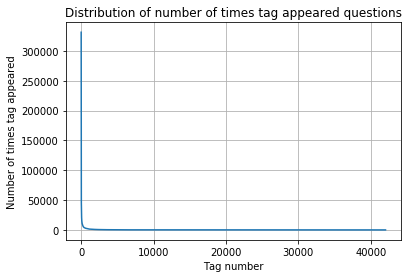

In [17]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

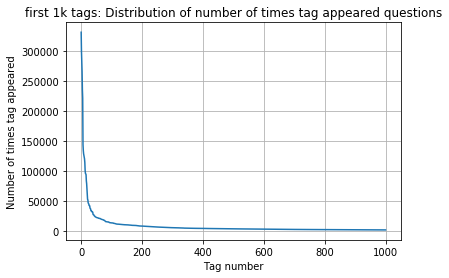

200 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483
   3453   3427   3396   3363   3326   3299   3272   3232   3196   3168
   3123   3094   3073   3050   3012   2986   2983   2953   2934   2903
   2891   2844   2819   2784   2754   2738   2726   2708   2681   2669
   2647   2621   2604   2594   2556   2527   2510   2482   2460   2444
  

In [27]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

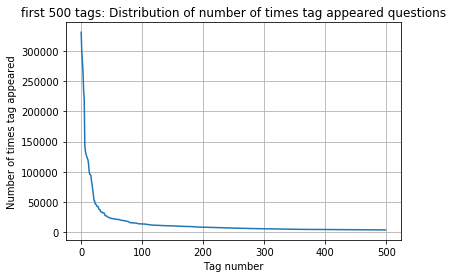

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483]


In [18]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

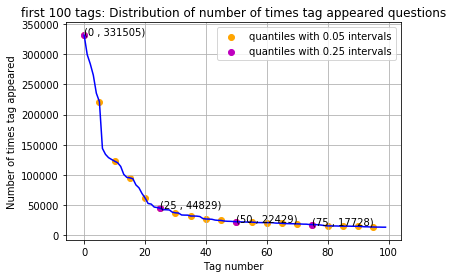

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [19]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [20]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

<h3> Tags Per Question </h3>

In [21]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206308 datapoints.
[2, 3, 4, 2, 2]


In [22]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899442


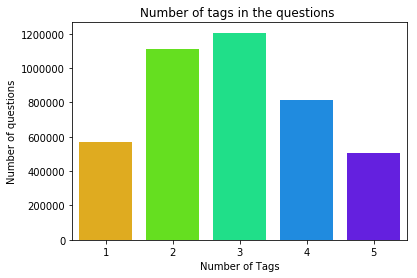

In [23]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

<h3> Most Frequent Tags </h3>

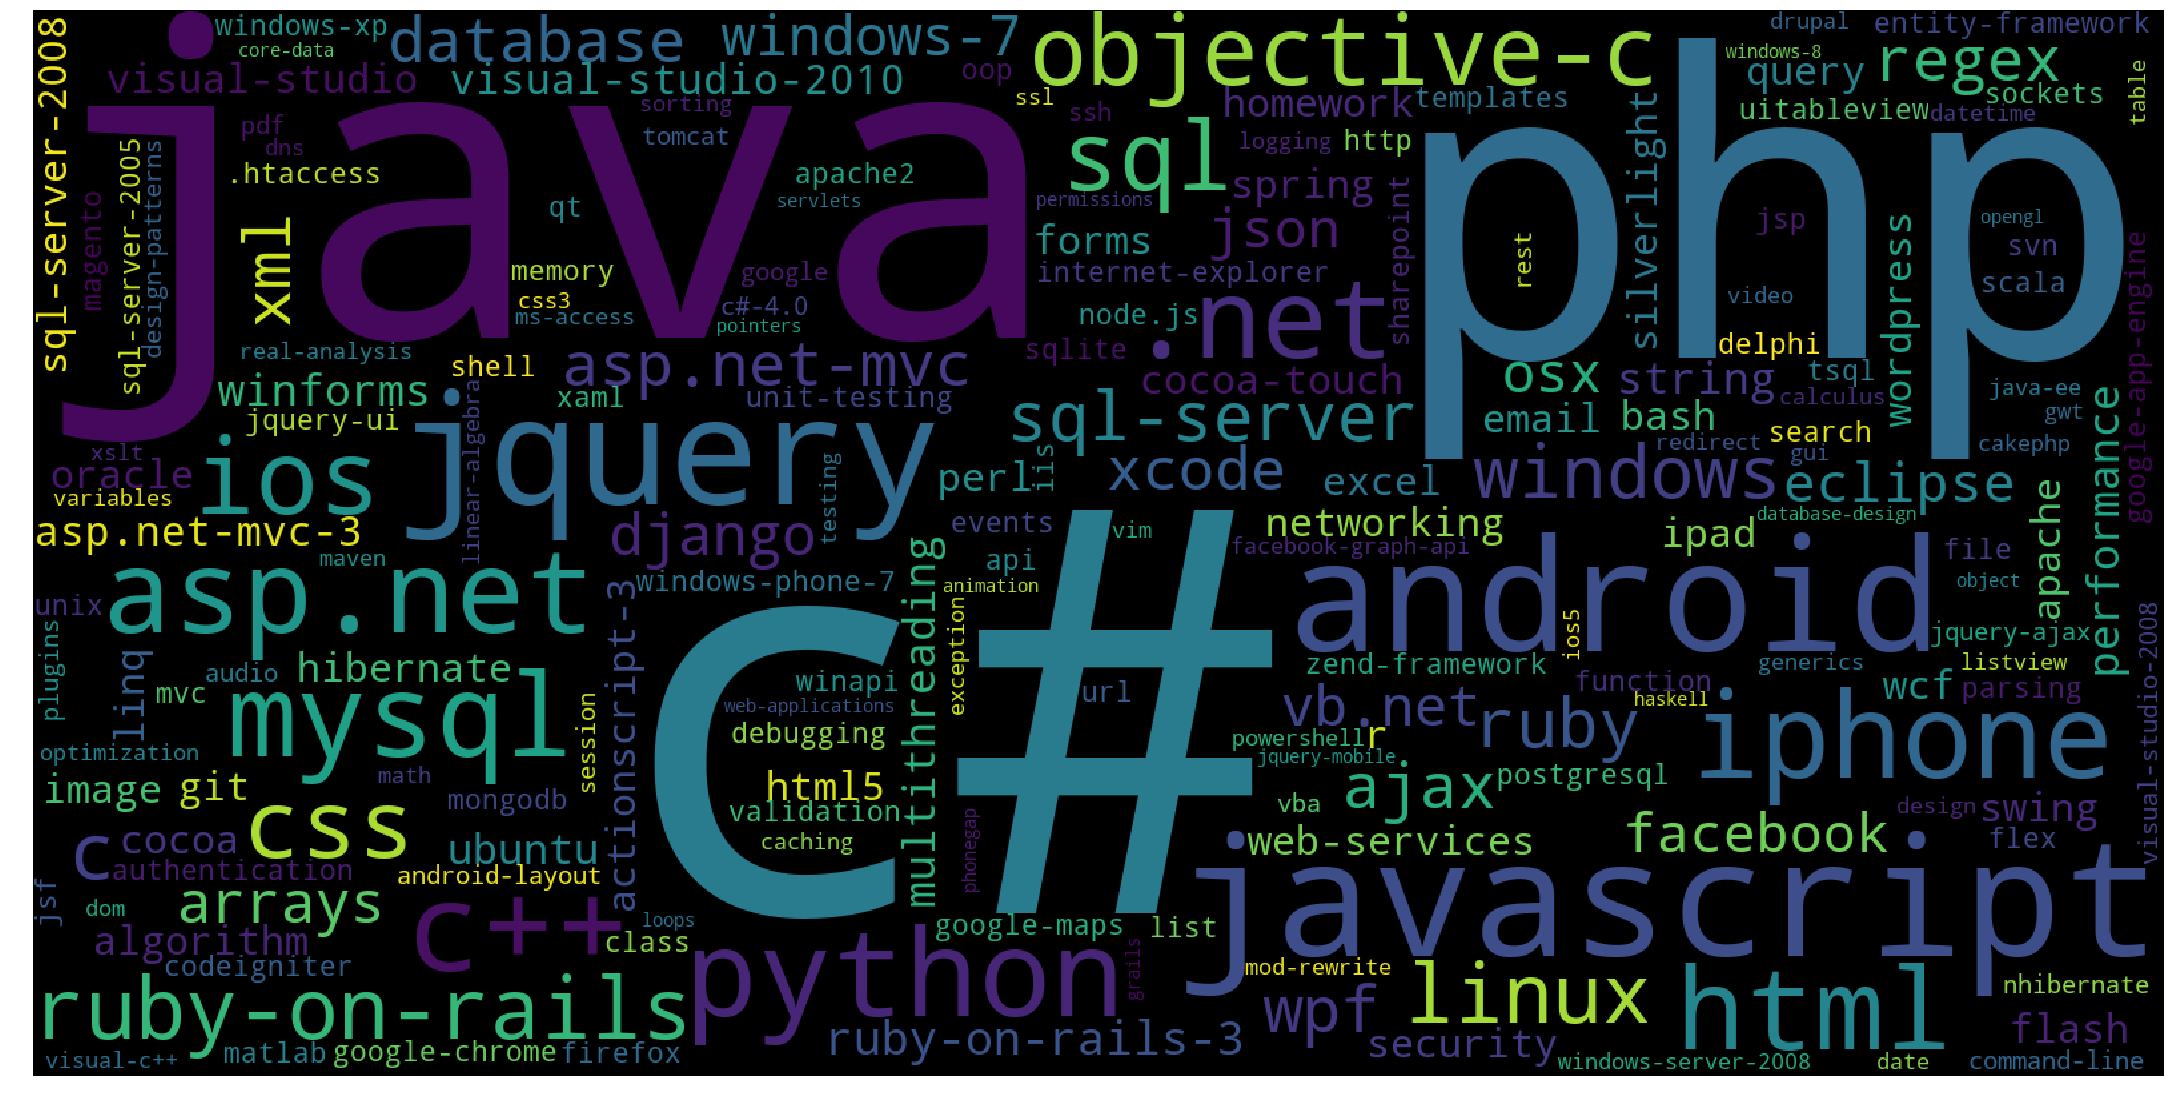

Time taken to run this cell : 0:00:18.853369


In [24]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

<h3> The top 20 tags </h3>

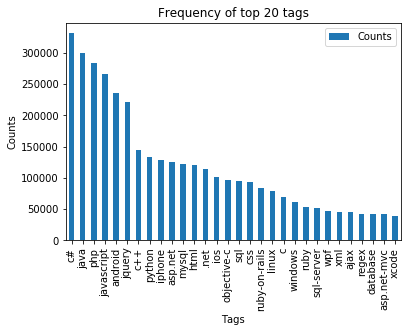

In [25]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

<h3> Cleaning and preprocessing of Questions </h3>

<ol> 
    <li> Sample 1M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

__ we create a new data base to store the sampled and preprocessed questions <br>Since, My laptop is taking a lot of time to process, that's why I have been randomly sampled approx 520000 observations__

In [2]:
sample = pd.read_csv('sample_data.csv', skiprows=lambda i: i % 2 != 0)

In [11]:
len(sample)

525789

In [4]:
#function to remove html
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [5]:
# function to process questions and code
def process_data(title, question, tags):
    
    is_code = 0

    if '<code>' in question:
        is_code = 1
    x = len(question)+len(title)

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question = re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question = striphtml(question.encode('utf-8'))

    title = title.encode('utf-8')

    question = str(title) +" "+ str(question)
    question = re.sub(r'[^A-Za-z]+',' ', question)
    words = word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question = ' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    return question, code, tags, x, len(question), is_code

In [12]:
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0

new_df = pd.DataFrame()
for index, row in sample.iterrows():
    question, code, tags, prev_len, post_len, is_code = process_data(row['Title'], row['Body'], row['Tags'])
    questions_proccesed += 1
    len_pre += prev_len
    len_post += post_len
    if is_code == 1:
        questions_with_code += 1
    new_row = pd.Series([question, code, prev_len, post_len, is_code, tags], index = ['question', 'code', 'prev_len', 'post_len', 'is_code', 'tags'])
    new_df = new_df.append(new_row, ignore_index = True)
    if questions_proccesed % 40000 == 0:
        print(f'Number of questions processed: {questions_proccesed}')

Number of questions processed: 40000
Number of questions processed: 80000
Number of questions processed: 120000
Number of questions processed: 160000
Number of questions processed: 200000
Number of questions processed: 240000
Number of questions processed: 280000
Number of questions processed: 320000
Number of questions processed: 360000
Number of questions processed: 400000
Number of questions processed: 440000
Number of questions processed: 480000
Number of questions processed: 520000


In [13]:
# saving the processed data to a CSV file
new_df.to_csv('processed_data.csv', sep=',', index=False, header=new_df.columns, encoding='utf-8')

In [18]:
no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed
print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

Avg. length of questions(Title+Body) before processing: 1220
Avg. length of questions(Title+Body) after processing: 327
Percent of questions containing code: 57


In [80]:
#some processed questions
for i in range(5):
    print(new_df['question'][i])
    print('='*127)

sql inject issu prevent correct form submiss php check everyth think make sure input field safe type sql inject good news safe bad news one tag mess form submiss place even touch life figur exact html use templat file forgiv okay entir php script get execut see data post none forum field post problem use someth titl field none data get post current use print post see submit noth work flawless statement though also mention script work flawless local machin use host come across problem state list input test mess
subqueri return row error new web program tri make twitter clone point tabl user id name id auto generat id name user tweet id content user id id auto generat id content text tweet user id id user made post follow id user id follow id id auto generat id user id user follow follow id user follow new sql well tri build sql statement would return tweet current log user everyon follow tri use statement work sometim time get error say subqueri return row statement put exampl would id 

In [16]:
new_df.head(5)

,code,is_code,post_len,prev_len,question,tags
0,"['{$variables}', '&lt;div width=""100%""&gt;\r\r...",1.0,515.0,5042.0,sql inject issu prevent correct form submiss p...,php forms
1,['SELECT * FROM tweets \r\r\nWHERE user_id IN\...,1.0,546.0,1507.0,subqueri return row error new web program tri ...,sql subquery
2,[],0.0,155.0,268.0,fi fl result big like symbol use lyx xetex out...,fonts xetex lyx ligatures
3,[],0.0,275.0,755.0,thing divis zero c possibl duplic valu return ...,c++ c visual-c++
4,"['@Local\r\r\n@Path(""RequestReport"")\r\r\npubl...",1.0,402.0,2531.0,access local session bean expos resteasi inter...,ejb resteasy


In [22]:
preprocessed_data = pd.read_csv('processed_data.csv', usecols = ['question', 'tags'])

In [23]:
preprocessed_data.head()

,question,tags
0,sql inject issu prevent correct form submiss p...,php forms
1,subqueri return row error new web program tri ...,sql subquery
2,fi fl result big like symbol use lyx xetex out...,fonts xetex lyx ligatures
3,thing divis zero c possibl duplic valu return ...,c++ c visual-c++
4,access local session bean expos resteasi inter...,ejb resteasy


In [24]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 525789
number of dimensions : 2


<h1> Machine Learning Models </h1>

<h2> Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [25]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ We will sample the number of tags instead considering all of them (due to limitation of computing power) __

In [32]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [33]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

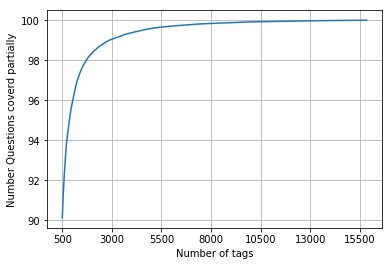

with  5500 tags we are covering  99.056 % of questions
with  500 tags we are covering  90.129 % of questions


In [34]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [35]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 51903 out of  525789


<h2> Split the data into test and train (80:20) </h2>

In [40]:
total_size = preprocessed_data.shape[0]
train_size = int(0.80*total_size)
train_datasize = 425789

x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 425789)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [41]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (425789, 500)
Number of data points in test data : (100000, 500)


<h2> Featurizing data </h2>

In [42]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])

In [43]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (425789, 89668) Y : (425789, 500)
Dimensions of test data X: (100000, 89668) Y: (100000, 500)


<h2> Applying Logistic Regression with OneVsRest Classifier </h2>

<h4> Modeling with less data points (0.5M data points) due to limited computing power of my laptop. </h4>

In [44]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.21836
Hamming loss  0.00287526
Micro-average quality numbers
Precision: 0.7005, Recall: 0.3522, F1-measure: 0.4687
Macro-average quality numbers
Precision: 0.5034, Recall: 0.2388, F1-measure: 0.3098
             precision    recall  f1-score   support

          0       0.61      0.25      0.36      6059
          1       0.77      0.44      0.56      6271
          2       0.81      0.54      0.64      8311
          3       0.69      0.41      0.52      7864
          4       0.92      0.75      0.83      5183
          5       0.88      0.72      0.79      9556
          6       0.74      0.34      0.46      3812
          7       0.87      0.60      0.71      3473
          8       0.73      0.46      0.56      4302
          9       0.79      0.44      0.56      2796
         10       0.83      0.59      0.69      3090
         11       0.48      0.17      0.25      3392
         12       0.46      0.09      0.15      1658
         13       0.61      0.31      0.41   

C:\Users\AAKASH\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AAKASH\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AAKASH\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<h4> Modeling with less data points (0.5M data points) and more weight to title. </h4>

In [55]:
more_wt_questions_df = pd.DataFrame()
more_wt_questions_df['question_3_times'] = new_df['question']*3
more_wt_questions_df['tags'] = new_df['tags']

In [56]:
more_wt_questions_df['question_3_times'][1]

'subqueri return row error new web program tri make twitter clone point tabl user id name id auto generat id name user tweet id content user id id auto generat id content text tweet user id id user made post follow id user id follow id id auto generat id user id user follow follow id user follow new sql well tri build sql statement would return tweet current log user everyon follow tri use statement work sometim time get error say subqueri return row statement put exampl would id current log user luck statement help would great appreci thanksubqueri return row error new web program tri make twitter clone point tabl user id name id auto generat id name user tweet id content user id id auto generat id content text tweet user id id user made post follow id user id follow id id auto generat id user id user follow follow id user follow new sql well tri build sql statement would return tweet current log user everyon follow tri use statement work sometim time get error say subqueri return row

In [58]:
preprocessed_data = more_wt_questions_df
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 525789
number of dimensions : 2


<h2> Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [60]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [61]:
total_size = preprocessed_data.shape[0]
train_size = int(0.80*total_size)
train_datasize = 425789

x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 425789)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [62]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (425789, 500)
Number of data points in test data : (100000, 500)


In [64]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question_3_times'])
x_test_multilabel = vectorizer.transform(x_test['question_3_times'])

In [65]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (425789, 90307) Y : (425789, 500)
Dimensions of test data X: (100000, 90307) Y: (100000, 500)


In [66]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.20091
Hamming loss  0.00296926
Micro-average quality numbers
Precision: 0.6876, Recall: 0.3218, F1-measure: 0.4384


C:\Users\AAKASH\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AAKASH\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro-average quality numbers
Precision: 0.4974, Recall: 0.2242, F1-measure: 0.2955
             precision    recall  f1-score   support

          0       0.62      0.23      0.34      6059
          1       0.76      0.42      0.54      6271
          2       0.80      0.50      0.62      8311
          3       0.68      0.39      0.49      7864
          4       0.91      0.73      0.81      5183
          5       0.87      0.59      0.70      9556
          6       0.73      0.32      0.44      3812
          7       0.85      0.55      0.67      3473
          8       0.71      0.37      0.48      4302
          9       0.78      0.42      0.55      2796
         10       0.81      0.55      0.65      3090
         11       0.47      0.16      0.24      3392
         12       0.46      0.09      0.15      1658
         13       0.57      0.25      0.34      3070
         14       0.48      0.17      0.25      2423
         15       0.55      0.25      0.34      1758
         16   

C:\Users\AAKASH\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


__Summary: <br>Without increasing the weight of Question titles and body we are getting precision of 70% and recall of 35%, and micro-averaged F1 score as 47%.__